In [1]:
import tensorflow as tf
import numpy as np
import tflearn
import random
import cv2
import os

from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tqdm import tqdm

In [2]:
TRAIN = "data/train/"
TEST = "data/test1/"
SIZE = 50
LR = 0.001
MODEL_NAME = 'models/dogsvscats-{}.model'.format(LR)

In [3]:
def load_image_grayscale(filename, shape):
    return cv2.resize(cv2.imread(filename, cv2.IMREAD_GRAYSCALE), shape)

In [4]:
def load_data(filename):
    label = filename.split('.')[0]
    if label == 'cat':
        return (1,0)
    elif label == 'dog':
        return (0,1)

In [5]:
def generate_train_data():
    train = []
    for image in tqdm(os.listdir(TRAIN)):
        label = load_data(image)
        full_path = os.path.join(TRAIN, image)
        image = load_image_grayscale(full_path, (SIZE, SIZE))
        train.append([np.array(image),np.array(label)])
    random.shuffle(train)
    return train

In [6]:
def generate_test_data():
    test_data = []
    for image in tqdm(os.listdir(TEST)):
        full_path = os.path.join(TEST, image)
        image_class = image.split('.')[0]
        image = load_image_grayscale(full_path, (SIZE, SIZE))
        test_data.append([np.array(image), image_class])
    random.shuffle(test_data)
    return test_data

In [12]:
train_data = generate_train_data() 

100%|██████████| 25000/25000 [07:36<00:00, 54.73it/s]


In [13]:
tf.reset_default_graph()

In [7]:
cnn = input_data(shape=[None, SIZE, SIZE, 1], name='input')

cnn = conv_2d(cnn, 32, 5, activation='relu')
cnn = max_pool_2d(cnn, 5)

cnn = conv_2d(cnn, 64, 5, activation='relu')
cnn = max_pool_2d(cnn, 5)

cnn = conv_2d(cnn, 32, 5, activation='relu')
cnn = max_pool_2d(cnn, 5)

cnn = conv_2d(cnn, 64, 5, activation='relu')
cnn = max_pool_2d(cnn, 5)

cnn = conv_2d(cnn, 32, 5, activation='relu')
cnn = max_pool_2d(cnn, 5)

cnn = conv_2d(cnn, 32, 5, activation='relu')
cnn = max_pool_2d(cnn, 5)


cnn = fully_connected(cnn, 1024, activation='relu')
cnn = dropout(cnn, 0.8)

cnn = fully_connected(cnn, 2, activation='softmax')
cnn = regression(cnn, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')


model = tflearn.DNN(cnn, tensorboard_dir='log')

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [15]:
train = train_data[:-500]
test = train_data[-500:]

In [28]:
X_train = np.array(list(map(lambda t: t[0], train))).reshape(-1,SIZE,SIZE,1)
y_train = np.array(list(map(lambda t: t[1], train)))

X_test = np.array(list(map(lambda t: t[0], test))).reshape(-1,SIZE,SIZE,1)
y_test = np.array(list(map(lambda t: t[1], test)))

In [29]:
X_train.shape

(24500, 50, 50, 1)

In [30]:
model.fit({'input': X_train}, {'targets': y_train}, n_epoch=7, 
          validation_set=({'input': X_test}, {'targets': y_test}), 
          snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3063  | total loss: 0.34242 | time: 171.856s
| Adam | epoch: 008 | loss: 0.34242 - acc: 0.8476 -- iter: 24448/24500
Training Step: 3064  | total loss: 0.35345 | time: 174.159s
| Adam | epoch: 008 | loss: 0.35345 - acc: 0.8441 | val_loss: 0.52906 - val_acc: 0.7620 -- iter: 24500/24500
--


In [31]:
model.save(MODEL_NAME)

INFO:tensorflow:/home/user/PycharmProjects/Pandas Practice/dogsvscats/models/dogsvscats-0.001.model is not in all_model_checkpoint_paths. Manually adding it.


In [8]:
if os.path.exists(f'{MODEL_NAME}.meta'):
    model.load(MODEL_NAME)

INFO:tensorflow:Restoring parameters from /home/user/PycharmProjects/Pandas Practice/dogsvscats/models/dogsvscats-0.001.model


In [70]:
image = load_image_grayscale("images/cat.0.jpg", (SIZE, SIZE))

In [55]:
image = image.reshape(-1, SIZE, SIZE, 1)

In [56]:
detector = ('cat', 'dog')

In [57]:
detector[np.argmax(model.predict(image))]

'cat'

In [66]:
my_test_images = list(map(lambda i: 'images/'+i, images))
my_test_images = list(map(lambda i: load_image_grayscale(i, (SIZE, SIZE)), my_test_images))
my_test_images = list(map(lambda i: i.reshape(-1, SIZE, SIZE, 1), my_test_images))

In [68]:
for img, real in zip(my_test_images, images):
    ans = model.predict(img)[0]
    print(f'With {max(ans)} % it is a {detector[np.argmax(ans)]}')
    print(f'Real answer: it is a {real[:4]}')
    print(f'path: images/{real}\n')

With 0.750589907169342 % it is a cat
Real answer: it is a cat.
path: images/cat.0.jpg

With 0.8083493113517761 % it is a dog
Real answer: it is a cat.
path: images/cat.1.jpg

With 0.7114077210426331 % it is a dog
Real answer: it is a cat.
path: images/cat.3.jpg

With 0.5466014742851257 % it is a cat
Real answer: it is a dog.
path: images/dog.1.jpg

With 0.9594040513038635 % it is a dog
Real answer: it is a cat.
path: images/cat.2.jpg

With 0.9298297762870789 % it is a dog
Real answer: it is a dog.
path: images/dog.0.jpg

With 0.7481564283370972 % it is a dog
Real answer: it is a dog.
path: images/dog.2.jpg





# Kaggle 
https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

if os.path.exists('data/test_data.npy'):
    test_data = np.load('data/test_data.npy')
else:
    test_data = generate_test_data()
    np.save('data/test_data.npy', test_data)

100%|██████████| 12500/12500 [03:23<00:00, 61.55it/s]


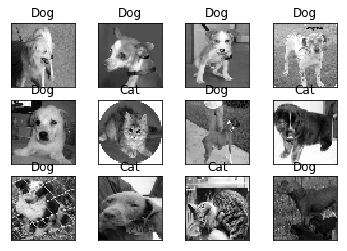

In [14]:
fig = plt.figure()

for num, data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    img_data = img_data.reshape(SIZE, SIZE, 1)
    model_out = model.predict([img_data])[0]
    
    str_label = 'Dog' if np.argmax(model_out) else 'Cat'

    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [22]:
result = list()

for data in tqdm(test_data):
    img_num = data[1]
    img_data = data[0]
    img_data = img_data.reshape(SIZE, SIZE, 1)
    model_out = model.predict([img_data])[0]
    result.append([img_num, model_out[1]])

100%|██████████| 12500/12500 [01:24<00:00, 147.87it/s]


In [28]:
df = pd.DataFrame(result, columns=['id','label'])
df.set_index('id', inplace=True)

In [29]:
df.head()

,label
id,
747,0.912903
11478,0.520747
11843,0.418453
2574,0.102359
5292,0.949510


In [31]:
df.to_csv('data/submission-file.csv')